In [1]:
#Kütüphaneler
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, wget
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.metrics import plot_confusion_matrix 
from wordcloud import WordCloud
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")
from helper_prabowo_ml import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct, hashtags
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

2023-12-26 00:19:09.504048: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-26 00:19:09.504503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-26 00:19:09.618708: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-26 00:19:09.855995: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-26 00:19:13.964600: W tensorflow/compiler/tf2tenso

100% [..........................................................] 13881 / 13881

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/huseyin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# veri yükleme
df = pd.read_csv("Language_Detection.csv")
df = df.sample(frac=1)
df.head()

,Text,Language
4627,oke laten we beginnen.,Dutch
10089,ಬೆರಳುಗಳು ದಾಟಿದೆ.,Kannada
2563,"[41] Em 2006, cerca de 1 800 artigos foram adi...",Portugeese
533,Articles depicting what some critics have call...,English
5907,άδεια.,Greek


In [3]:
#Tekrarlı veri kontrolu
df.duplicated().sum()

66

In [4]:
#Tekrarlı veriyi silme
df.drop_duplicates(inplace= True)

In [5]:
#satır ve sütun sayısı
df.shape

(10271, 2)

In [6]:
# diller
df.Language.unique()

array(['Dutch', 'Kannada', 'Portugeese', 'English', 'Greek', 'French',
       'German', 'Malayalam', 'Spanish', 'Sweedish', 'Arabic', 'Turkish',
       'Tamil', 'Russian', 'Italian', 'Hindi', 'Danish'], dtype=object)

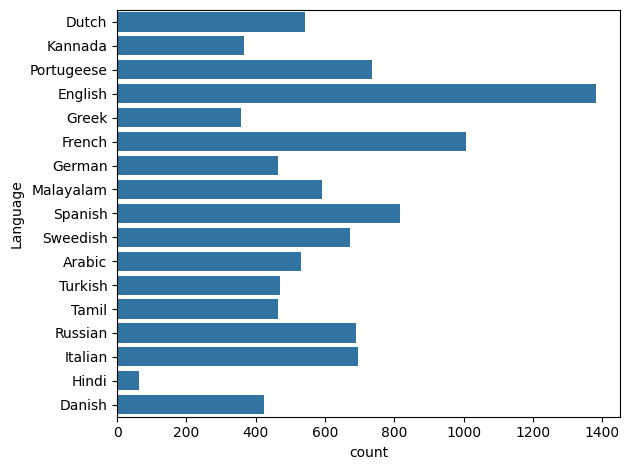

In [7]:
# diilerin dağılışı
sns.countplot(df.Language)
plt.tight_layout();

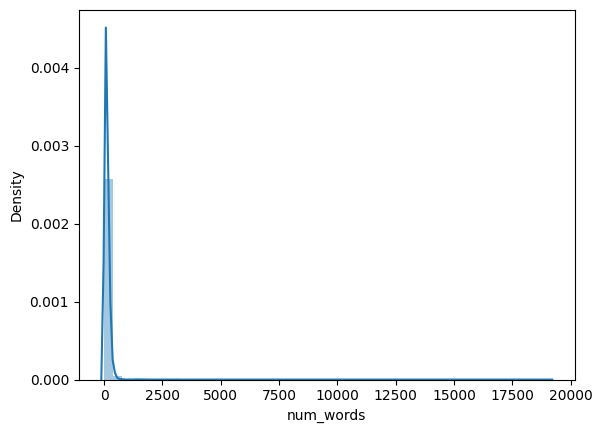

In [8]:
df['num_words'] = df.Text.apply(len)
sns.distplot(df.num_words);

In [9]:
df.num_words.describe()

count    10271.000000
mean       124.742966
std        254.349901
min          1.000000
25%         44.000000
50%        100.000000
75%        166.000000
max      19088.000000
Name: num_words, dtype: float64

In [10]:
# veri önişleme
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [11]:
preprocessed_df = text_preprocess(df,'Text')
preprocessed_df.head()

,Text,Language,num_words
4627,oke laten beginnen,Dutch,22
10089,,Kannada,16
2563,em cerca de artigos foram adicionados diariame...,Portugeese,125
533,articles depicting critics called objectionabl...,English,253
5907,,Greek,6


In [12]:
# encooding langage
labels_dict = {}
for idx, lang in enumerate(preprocessed_df.Language.unique()):
    labels_dict[lang] = idx
labels_dict

{'Dutch': 0,
 'Kannada': 1,
 'Portugeese': 2,
 'English': 3,
 'Greek': 4,
 'French': 5,
 'German': 6,
 'Malayalam': 7,
 'Spanish': 8,
 'Sweedish': 9,
 'Arabic': 10,
 'Turkish': 11,
 'Tamil': 12,
 'Russian': 13,
 'Italian': 14,
 'Hindi': 15,
 'Danish': 16}

In [13]:
preprocessed_df['Label'] = preprocessed_df.Language.map(labels_dict)
preprocessed_df.head()

,Text,Language,num_words,Label
4627,oke laten beginnen,Dutch,22,0
10089,,Kannada,16,1
2563,em cerca de artigos foram adicionados diariame...,Portugeese,125,2
533,articles depicting critics called objectionabl...,English,253,3
5907,,Greek,6,4


In [14]:
preprocessed_df.sample(frac=1)

,Text,Language,num_words,Label
9472,,Arabic,82,10
181,among ways classifying plants regional floras ...,English,182,3
3778,le https empchant les censeurs de voir quelle ...,French,259,5
3181,sade eu realmente aprecio isso,Portugeese,33,2
6921,jeg kunne ikke bryde mig mindre hvis nogen spr...,Danish,210,16
...,...,...,...,...
563,the wall street journal reported may tretikov ...,English,318,3
5119,esta organizacin se encarg de registrar los do...,Spanish,178,8
235,the remainder believed consist percent cold da...,English,99,3
5874,,Greek,22,4


In [15]:
# test ve train ayırma
train_df, test_df = train_test_split(preprocessed_df,test_size=0.3,random_state=42,shuffle=True,stratify=preprocessed_df.Language)

In [ ]:
# tokenization
tokenizer = AutoTokenizer.from_pretrained("papluca/xlm-roberta-base-language-detection")
xlm = TFAutoModelForSequenceClassification.from_pretrained("papluca/xlm-roberta-base-language-detection",from_pt=True)

2023-12-26 00:19:47.550228: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 768006144 exceeds 10% of free system memory.


In [ ]:
X_train = tokenizer(text=train_df.Text.tolist(),
                   max_length=125,
                   padding=True,
                   truncation=True,
                   add_special_tokens=True,
                   return_tensors="tf",
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=True)

X_test = tokenizer(text=test_df.Text.tolist(),
                  max_length=125,
                  padding=True,
                  truncation=True,
                  add_special_tokens=True,
                  return_tensors="tf",
                  return_attention_mask=True,
                  return_token_type_ids=False,
                  verbose=True)

In [ ]:
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

In [ ]:
embeddings = xlm(input_ids,attention_mask=attention_mask)[0] # 0 --> final hidden state, 1 --> pooling output
output = Flatten()(embeddings)
output = Dense(units=1024,activation='relu')(output)
output = Dropout(0.3)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.2)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.2)(output)
output = Dense(units=128,activation='relu')(output)
output = Dense(units=10,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers[2].trainable = True

In [ ]:
model.summary()

In [ ]:
plot_model(model,'model.png',show_shapes=True,dpi=100,rankdir='TB')

In [ ]:
optimizer = Adam(learning_rate=5e-5,epsilon=2e-8,decay=0.01,clipnorm=1.0)
loss = CategoricalCrossentropy()
metrics = CategoricalAccuracy('balanced_accuracy')
model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

In [ ]:
es = EarlyStopping(monitor='val_balanced_accuracy',patience=20,verbose=1,mode='max',restore_best_weights=True)
mc = ModelCheckpoint(filepath='checkpoint',monitor='val_balanced_accuracy',mode='max',save_best_only=True,verbose=1)

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
              y=to_categorical(train_df.Label),
              epochs=5,
              batch_size=64,
              callbacks=[es,mc],
              validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.Label))
             )

In [ ]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.title('Loss Graph')
plt.legend();

In [ ]:
plt.plot(r.history['balanced_accuracy'],'r',label='train balanced accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test balanced accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Categorical Balanced Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [ ]:
model.save('language_detector.h5')

In [ ]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.Label))
print("Categorical Cross-entropy Loss:", loss)
print("Categorical Accuracy:", acc)

In [ ]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print("Confusion Matrix:")
print(confusion_matrix(test_df.Label,test_predictions))
print('-----------------------------')
print("Encoded Labels:")
print(labels_dict)
print('-----------------------------')
print("Classification Report:")
print(classification_report(test_df.Label,test_predictions))